# Determining the Ice thickness of Vatnajokull based on H/V spectral ratio

## Importing modules

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
from normalize import normalize

## Functions

In [6]:
def distance_station(stt) :
    DIST_orign = [0]
    for i in range(1,len(stt)) :
        diff_X = float(stt[i][1]) - float(stt[i-1][1])
        diff_Y = float(stt[i][2]) - float(stt[i-1][2])
        dist = (diff_X**2+diff_Y**2)**(1/2)
        DIST_orign.append((DIST_orign[i-1]*1000+dist)/1000)
    return DIST_orign
DIST = distance_station(stt)
print(len(DIST))
#print(DIST)

6


In [3]:
root = "D:\MEMOIRE\Ice_thickness"
alt_glacier = '\point_altitude_glacier\point_altitude_glacier.csv'
station = "\lt_nodes_ablation_lambert.csv"
hvsr_fold = "D:\MEMOIRE\Geopsy_res\DATE_7_12"

In [4]:
with open(root+alt_glacier) as file :
    glac_alt = []
    pos = []
    line = 0
    readcsv = csv.reader(file, delimiter=',')
    for row in readcsv :
        if line > 0 :
            glac_alt.append(float(row[-1]))
            pos.append(float(row[3])/1000)
        line += 1
print(len(pos))
print(len(glac_alt))

1430
1430


In [5]:
filepath = root+station
print(filepath)
with open(filepath) as file :
    stt = []
    readcsv = csv.reader(file, delimiter=',')
    i = 0
    line = 0
    for row in readcsv :
        if line > 0 :
            stt.append([row[1]])
            stt[i].extend(row[4:7])
            i += 1
        line += 1
        
def sortThird(val):
    return val[2]
stt.sort(key=sortThird)

node_alt = []
name_station = []
for line in stt :
    node_alt.append(float(line[3]))
    name_station.append(line[0])

print(len(node_alt))

D:\MEMOIRE\Ice_thickness\lt_nodes_ablation_lambert.csv
6


In [7]:
stt

[['20773', '1756930.67057778', '1205501.31065622', '852'],
 ['20781', '1757497.77467811', '1211646.50005961', '1010'],
 ['20769', '1757998.30222875', '1219120.85828483', '1159'],
 ['20774', '1763952.64283821', '1223207.58530924', '1294'],
 ['20739', '1769274.68255682', '1227414.53980666', '1445'],
 ['20754', '1772111.64287197', '1232383.33887074', '1505']]

In [8]:
print(name_station)

['20773', '20781', '20769', '20774', '20739', '20754']


###### La oldest ice : Qu'est-ce que c'est ? partir sur où on la trouve, comment on la trouve et quel est l'intéret.

In [9]:
F0 = []
vs = 1900
H = []

YERRORHIGH = []
YERRORLOW = []
YERROR = []

FREQ = []
AMP_AVE = []

for nme_stt in name_station :   
    filepath = hvsr_fold+'\SS_'+ nme_stt +'.hv'
    print(filepath)
    line = 0
    with open(filepath) as file :
        tmpFREQ = []
        tmpAMP_AVE = []
        readcsv = csv.reader(file, delimiter='\t')
        for row in readcsv :
            line += 1
            if line == 5 :
                #print(row)
                f0 = float(row[1]) #extracting the f0 in the hv file
                #print(row[2])
                F0.append(f0)
                h = vs/(4.0*f0) #calculation of ice thickness
                H.append(h) #save ice thickness in a list
                yhigh = vs/(4.0*(float(row[3]))) #calculate the standart deviation of f0
                ylow = vs/(4.0*(float(row[2])))
                YERRORHIGH.append(h-yhigh)
                YERRORLOW.append(ylow-h)
            if line >= 10 and float(row[0]) >= 0.5  :
                tmpFREQ.append(float(row[0]))
                tmpAMP_AVE.append(float(row[1]))
    FREQ.append(np.array(tmpFREQ))
    AMP_AVE.append(np.array(tmpAMP_AVE))

FREQ = np.array(FREQ, dtype=object)
AMP_AVE = np.array(AMP_AVE, dtype=object)

BED_ALT = np.subtract(node_alt, H)
XERROR = ((vs/4)*np.power(F0, -1))/1000 #Lambda/4 where lambda = Vs/f0
#YERRORHIGH = 10*np.array(YERRORHIGH)
YERROR.append(YERRORLOW)
YERROR.append(YERRORHIGH)
#print(F0)
#print(H)
#print(BED_ALT)
#print(XERROR)
#print(YERROR)

D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20773.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20781.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20769.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20774.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20739.hv
D:\MEMOIRE\Geopsy_res\DATE_7_12\SS_20754.hv


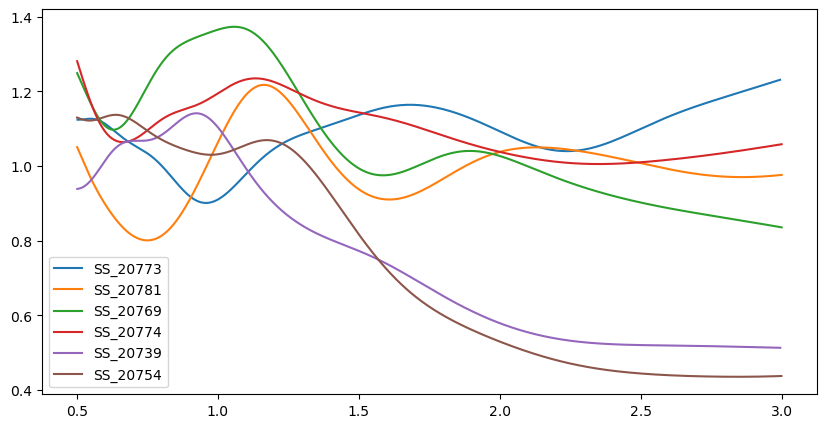

In [10]:
fig = plt.figure(figsize=(10,5))
for i in range(len(FREQ)) :
    plt.plot(FREQ[i], AMP_AVE[i], label='SS_'+str(name_station[i]))
plt.legend()
plt.savefig('plot_ice_thick/HVCurve.png')
plt.show()

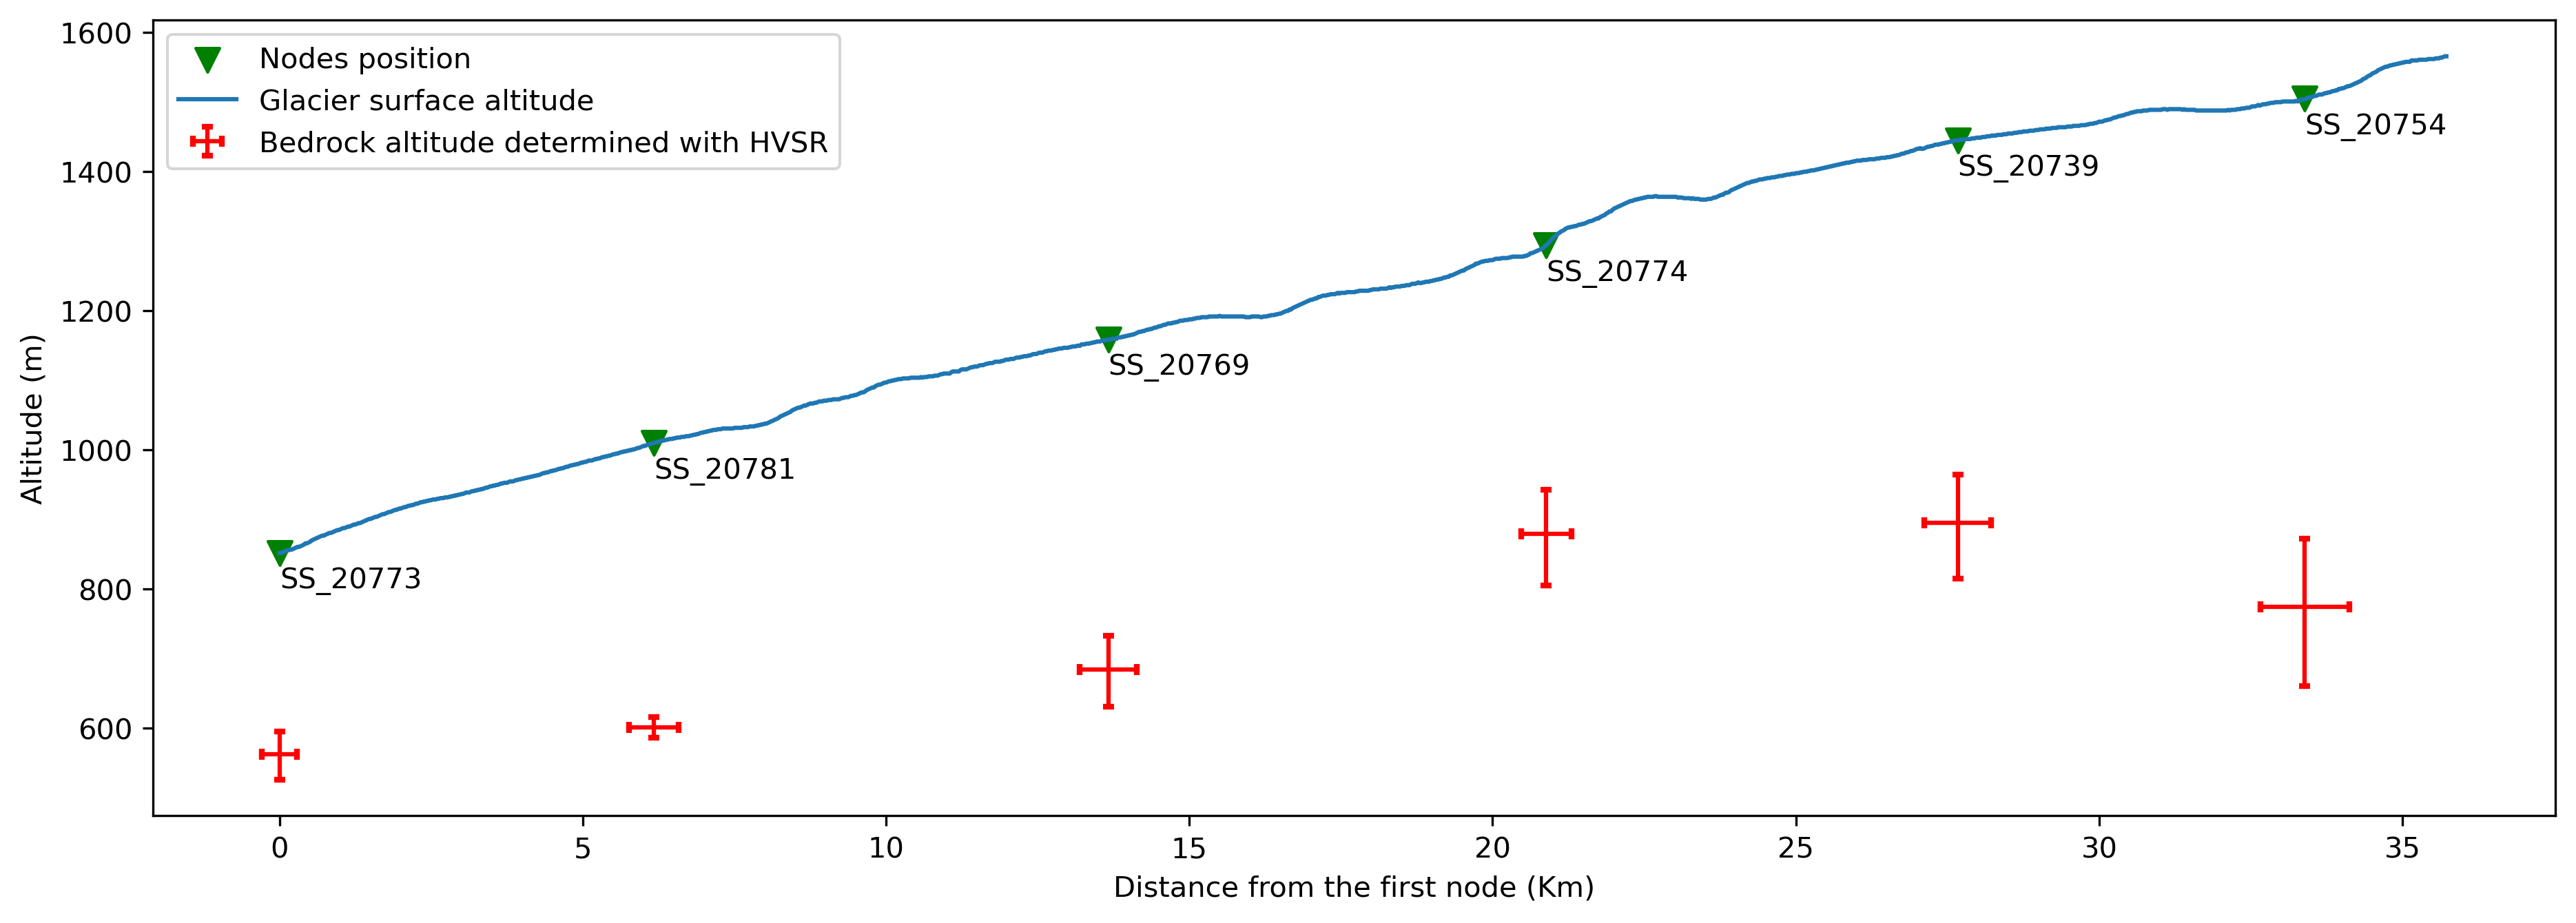

In [11]:
plt.figure(figsize=(15, 5), dpi=300)
plt.scatter(DIST, node_alt, s=70 , c='green', marker='v', label = 'Nodes position')
#plt.scatter(DIST, BED_ALT, s=60, c='red',marker='o')
plt.plot(pos, glac_alt, label = 'Glacier surface altitude')
plt.errorbar(DIST,BED_ALT,xerr = XERROR, yerr = YERROR, linestyle='None', ecolor= 'red', capsize=2, capthick=2, label = 'Bedrock altitude determined with HVSR')
for i in range(len(DIST)) :
    plt.text(DIST[i],node_alt[i]-50,'SS_'+name_station[i])
plt.xlabel('Distance from the first node (Km)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.savefig('plot_ice_thick/ice_thickness.png')
plt.show()

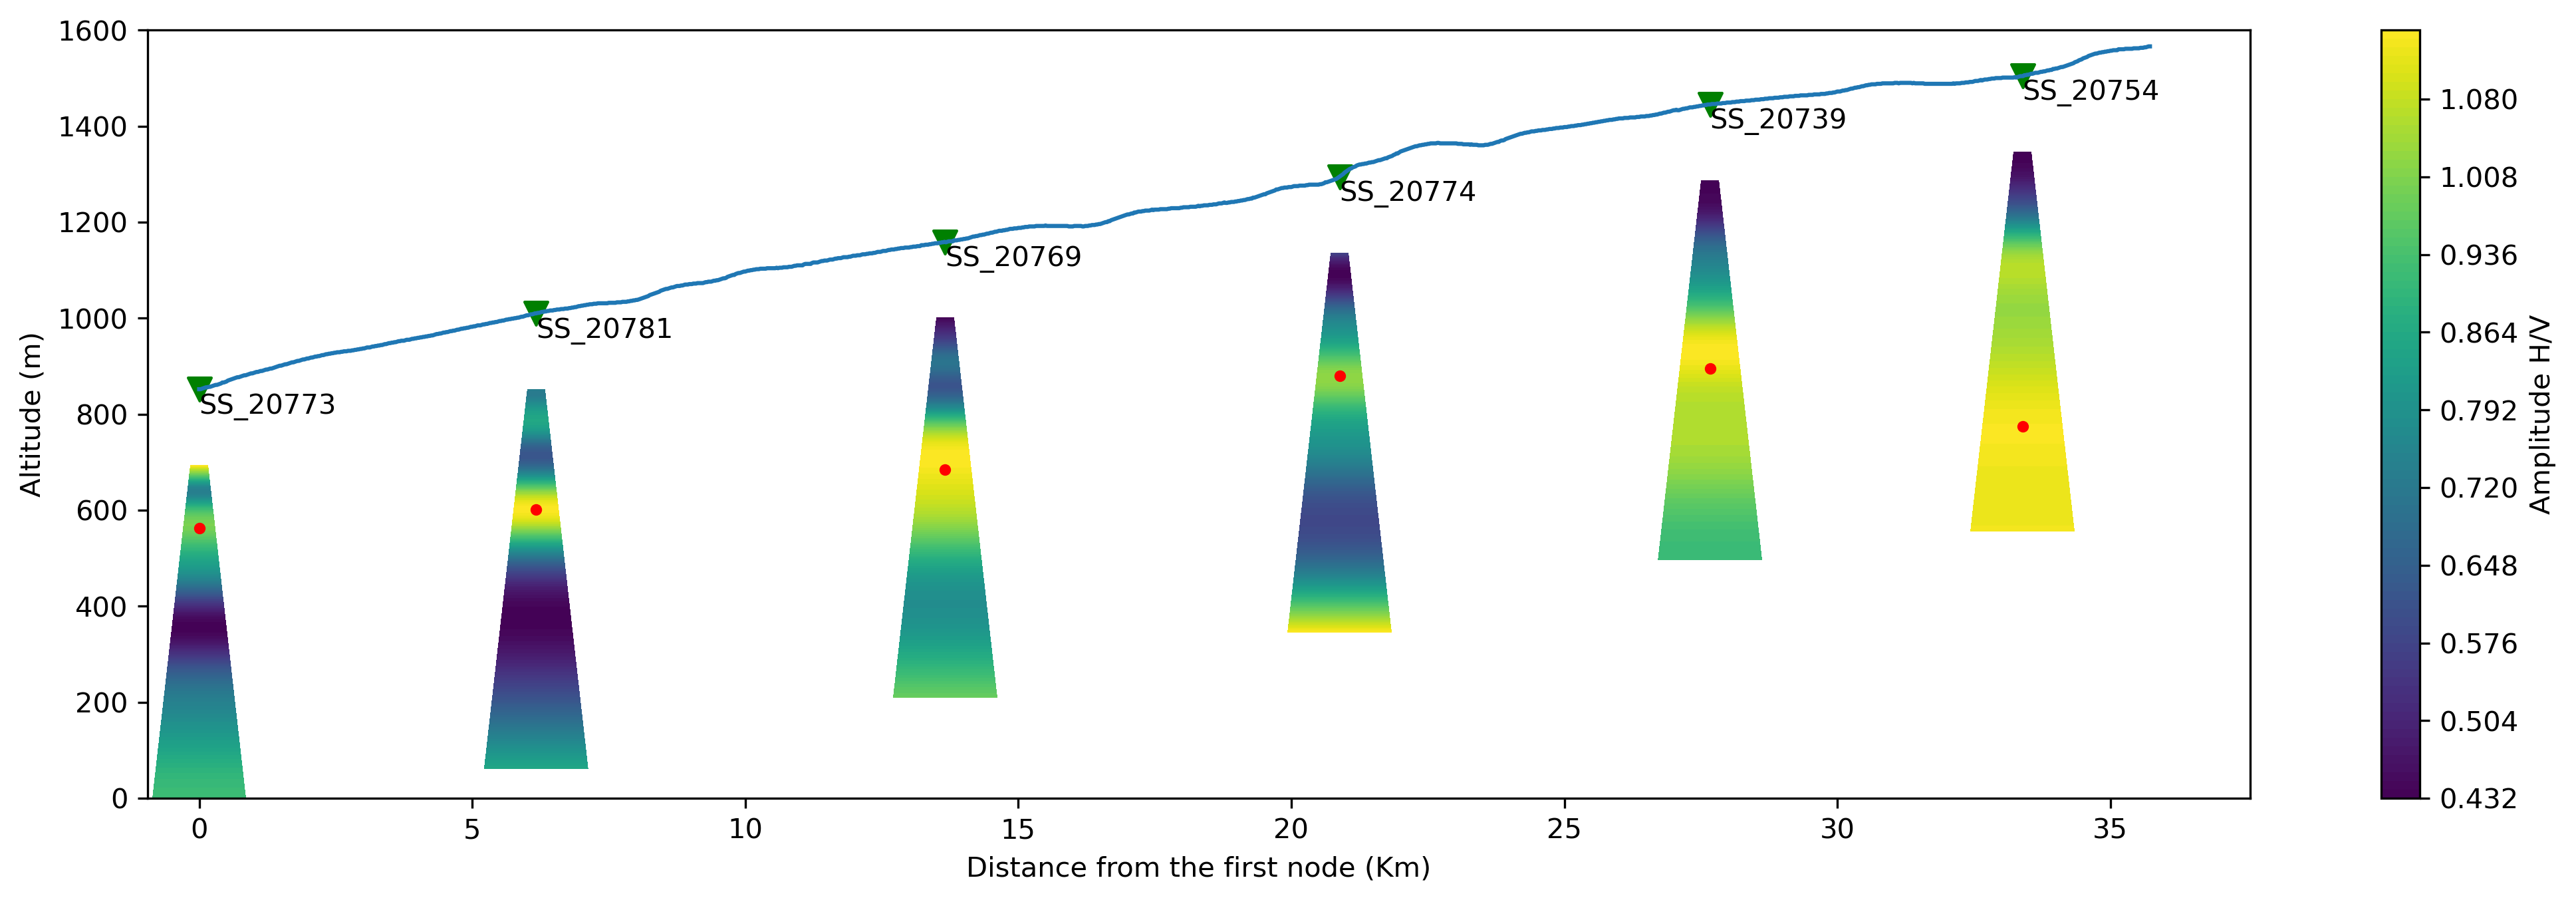

In [12]:
plt.figure(figsize=(17, 5), dpi=300)

for i in range(len(FREQ)) :
    L0 = [DIST[i]]*len(FREQ[i])
    L01 = L0 - ((vs/4)*np.power(FREQ[i], -1))/1000
    L1 = L0 + ((vs/4)*np.power(FREQ[i], -1))/1000
    L = []
    L.append(L01)
    L.append(L0)
    L.append(L1)
    L = np.array(L)
    
    HTOT = 1900/(4*np.array(FREQ[i]))
    HTOT = node_alt[i] - HTOT
    
    testFREQ = []
    testFREQ.append(HTOT)
    testFREQ.append(HTOT)
    testFREQ.append(HTOT)
    testFREQ = np.array(testFREQ)

    testAMP = []
    testAMP.append(AMP_AVE[i])
    testAMP.append(AMP_AVE[i])
    testAMP.append(AMP_AVE[i])
    testAMP = np.array(testAMP)
    plt.ylim(0,1600)
    plt.contourf(L, testFREQ, testAMP, 100)
   
plt.colorbar(label = "Amplitude H/V")
plt.scatter(DIST, node_alt, s=70 , c='green', marker='v', label = 'Nodes position')
plt.plot(pos, glac_alt, label = 'Glacier surface altitude')
plt.scatter(DIST, BED_ALT, s=10, c='red',marker='o')
#plt.errorbar(DIST,BED_ALT,xerr = XERROR, yerr = YERROR, linestyle='None', ecolor= 'red', capsize=2, capthick=2, label = 'Bedrock altitude determined with HVSR')
for i in range(len(DIST)) :
    plt.text(DIST[i],node_alt[i]-50,'SS_'+name_station[i])
plt.xlabel('Distance from the first node (Km)')
plt.ylabel('Altitude (m)')
plt.savefig('plot_ice_thick/HVintensity_ice_thickness.png')
plt.show()


# Automated continuous HVSR computing with hvsrpy module

Credit : https://github.com/jpvantassel/hvsrpy/blob/main/examples/simple_hvsrpy_interface.ipynb

## Importing modules and libraries

In [13]:
import hvsrpy
import obspy
import time
import datetime
import sigpropy

## Functions

In [5]:
def hvsr_export(filename, fields, ROW) :
    with open(filename, 'w') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 

        # writing the fields 
        csvwriter.writerow(fields) 

        # writing the data rows 
        csvwriter.writerows(ROW)

In [27]:
def hv_maximum(sensor, windowlenght, f_min, f_max) :
    startprocess = time.process_time() 
    
    distribution_mc = "lognormal"
    
    width = 0.1 #Width of cosine taper {0. - 1.}. Geopsy default of 0.05 is equal to 0.1 -> 0.1 is recommended
    bandwidth = 40 # Konno and Ohmachi smoothing constant


    # Boolean to control whether Butterworth filter is applied. 
    # Geopsy does not apply a bandpass filter.
    filter_bool = False        
    # Low-cut frequency for bandpass filter.
    filter_flow = 0.1                   
    # High-cut frequency for bandpass filter.
    filter_fhigh = 30                   
    # Filter order.
    filter_order = 5
    bp_filter = {"flag":filter_bool, "flow":filter_flow, "fhigh":filter_fhigh, "order":filter_order}

    # Minimum frequency after resampling
    resample_fmin = f_min  
    # Maximum frequency after resampling
    resample_fmax = f_max
    # Number of frequencies after resampling
    resample_fnum = 200
    # Type of resampling {'log', 'linear'}
    resample_type = 'log'

    resampling = {"minf":resample_fmin, "maxf":resample_fmax, "nf":resample_fnum, "res_type":resample_type}

    # Upper and lower frequency limits to restrict peak selection. To use the entire range use `None`.
    peak_f_lower = f_min
    peak_f_upper = f_max
    # Geopsy's default is "squared-average" -> "geometric-mean" is recommended.
    method = "geometric-mean"
    # If method="single-azimuth", set azimuth in degree clock-wise from north. If method!="single-azimuth", value is ignored.
    azimuth = 0

    hv = sensor.hv(windowlenght, bp_filter, width, bandwidth, resampling, method, 
               f_low=peak_f_lower, f_high=peak_f_upper, azimuth=azimuth)
    
    #max_freq = hv.mc_peak_frq(distribution_mc)
    
    #max_amp = hv.mc_peak_amp(distribution_mc)
    
    meanamp = hv.mean_curve(distribution_mc)
    
    frq = hv.frq
    
    endprocess = time.process_time()
    print('Processing accomplished in '+str(endprocess-startprocess)+' seconds')
    
    return meanamp, frq


## Continuous HVSR

### Computation of continuous HVSR and saving in CSV file

In [ ]:
windowlenght = 60 #second
f_min = 0.2
f_max = 40

startdate = '2022.05.08'

startdate = datetime.datetime.strptime(startdate, '%Y.%m.%d')
startnumber = 3
days = 31 - startnumber

HVFREQALL = []
HVAMPALL = []
HVTIMEALL = []

STATION = ["453020739."]#, "453020780."] #['453020781.', 



for namestt in STATION :

    HVFREQ = []
    HVAMP = []
    HVTIME = []
    for day in range(days) :
        
        date = startdate + datetime.timedelta(days = day)
        datetimeStr = date.strftime("%Y.%m.%d.%H.%M.%S.000")
        root = 'D:\\Nodes_ablation_zone\\All_comp_DP_\\'
        #root = 'D:\\Nodes_on_Vatna\\All_comp_DP_\\'
        
        traceE = obspy.read(root+namestt+str(startnumber+day)+'.'+datetimeStr+'.E.miniseed')
        traceN = obspy.read(root+namestt+str(startnumber+day)+'.'+datetimeStr+'.N.miniseed')
        traceZ = obspy.read(root+namestt+str(startnumber+day)+'.'+datetimeStr+'.Z.miniseed')
        
        dt = traceZ[0].stats.delta
        
        starttrace = traceZ[0].stats.starttime
        
        timesize = 10 #minutes

        dtnbr = int(timesize*60/dt)
        
        nbr_timestep = int(24*60/timesize)
        

        print('Starting the time loop')

        for i in range(nbr_timestep) :
            
            posstart = int(i*dtnbr)
            posend = int((i+1)*dtnbr+1)
            
            SigtraceE = sigpropy.TimeSeries(traceE[0].data[posstart:posend], dt)
            SigtraceN = sigpropy.TimeSeries(traceN[0].data[posstart:posend], dt)
            SigtraceZ = sigpropy.TimeSeries(traceZ[0].data[posstart:posend], dt)

            sensor = hvsrpy.Sensor3c(SigtraceN,SigtraceE,SigtraceZ)

            starttime = starttrace+i*timesize*60
            endtime = starttime+timesize*60
            
            print([starttime, endtime])
            
            meanamp, frq = hv_maximum(sensor, windowlenght, f_min, f_max)
            
            name = str(namestt)+str(day)+'.'+str(i)+'.csv'
            
            starttime = datetime.datetime.strptime(str(starttime), '%Y-%m-%dT%H:%M:%S.000000Z')
            endtime = datetime.datetime.strptime(str(endtime), '%Y-%m-%dT%H:%M:%S.000000Z')
            
            root = 'res_continuous_HVSR\\'
            filename = root+name
            headers = ['FREQ','AMP','starttime','endtime']
            ROW = []
            for j in range(len(frq)) :
                ROW.append([frq[j],meanamp[j],starttime, endtime])
            hvsr_export(filename, headers, ROW)
            
            
    #HVFREQALL.append(HVFREQ)
    #HVAMPALL.append(HVAMP)
    #HVTIMEALL.append(HVTIME)


Starting the time loop
[UTCDateTime(2022, 5, 8, 0, 0), UTCDateTime(2022, 5, 8, 0, 10)]
Processing accomplished in 0.53125 seconds
[UTCDateTime(2022, 5, 8, 0, 10), UTCDateTime(2022, 5, 8, 0, 20)]
Processing accomplished in 0.515625 seconds
[UTCDateTime(2022, 5, 8, 0, 20), UTCDateTime(2022, 5, 8, 0, 30)]
Processing accomplished in 0.515625 seconds
[UTCDateTime(2022, 5, 8, 0, 30), UTCDateTime(2022, 5, 8, 0, 40)]
Processing accomplished in 0.546875 seconds
[UTCDateTime(2022, 5, 8, 0, 40), UTCDateTime(2022, 5, 8, 0, 50)]
Processing accomplished in 0.5 seconds
[UTCDateTime(2022, 5, 8, 0, 50), UTCDateTime(2022, 5, 8, 1, 0)]
Processing accomplished in 0.484375 seconds
[UTCDateTime(2022, 5, 8, 1, 0), UTCDateTime(2022, 5, 8, 1, 10)]
Processing accomplished in 0.53125 seconds
[UTCDateTime(2022, 5, 8, 1, 10), UTCDateTime(2022, 5, 8, 1, 20)]
Processing accomplished in 0.5625 seconds
[UTCDateTime(2022, 5, 8, 1, 20), UTCDateTime(2022, 5, 8, 1, 30)]
Processing accomplished in 0.53125 seconds
[UTCDateT

### Plotting continuous HVSR from saved data in a CSV file

Jour : 0
Jour : 1
Jour : 2
Jour : 3
Jour : 4
Jour : 5
Jour : 6
Jour : 7
Jour : 8
Jour : 9
Jour : 10
Jour : 11
Jour : 12
Jour : 13
Jour : 14
Jour : 15
Jour : 16
Jour : 17
Jour : 18
Jour : 19
Jour : 20
Jour : 21
Jour : 22
Jour : 23
Jour : 24
Jour : 25
Jour : 26


C:\Users\julie\AppData\Local\Temp\ipykernel_6300\3940639399.py:51: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,10)


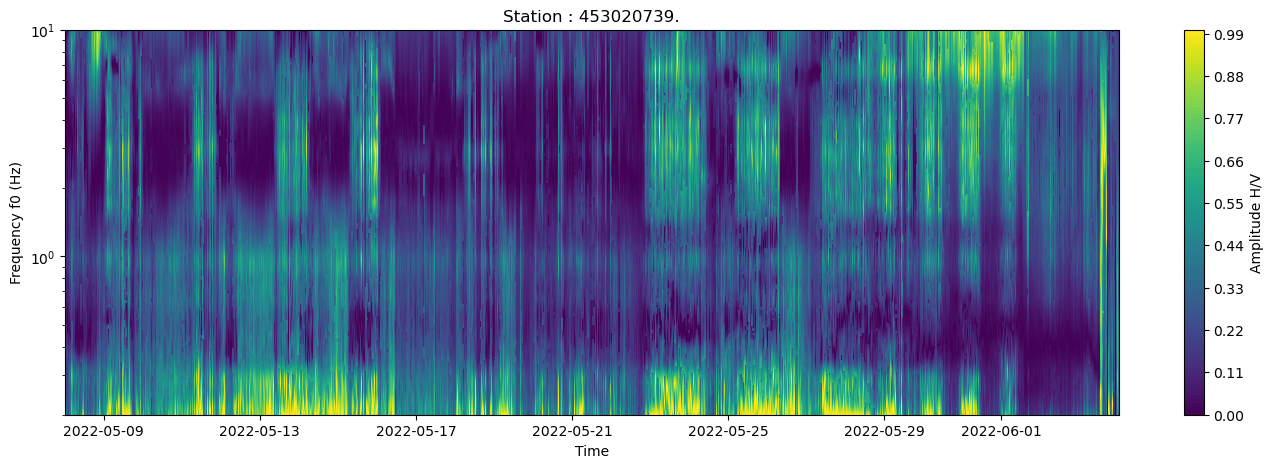

In [26]:
root = 'res_continuous_HVSR\\'
namestt = '453020739.'

fig = plt.figure(figsize=(17,5))


ContiHVTime = []
ContiHVFreq = []
ContiHVAmp = []

for day in range(27) :
    for i in range(72) :
        filename = str(namestt)+str(day)+'.'+str(i)+'.csv'
        filepath = root+filename
        line = 0
        tmpfrq = []
        tmpamp = []
        tmptimedep = []
        tmptimeend = []
        with open(filepath) as file :
                readcsv = csv.reader(file, delimiter=',')
                for row in readcsv :
                    if line > 0 and row != [] :
                        tmpfrq.append(float(row[0]))
                        tmpamp.append(float(row[1]))
                        tmptimedep.append(datetime.datetime.strptime(str(row[2]),'%Y-%m-%d %H:%M:%S'))
                        tmptimeend.append(datetime.datetime.strptime(str(row[3]),'%Y-%m-%d %H:%M:%S'))
                    line += 1
                    
        tmpamp = normalize(tmpamp)
        
        HTOT = 1900/(4*np.array(tmpfrq))
        
        ContiHVTime.append(tmptimedep)
        ContiHVTime.append(tmptimeend)
        ContiHVFreq.append(tmpfrq)
        ContiHVFreq.append(tmpfrq)
        ContiHVAmp.append(tmpamp)
        ContiHVAmp.append(tmpamp)
        
    print('Jour : '+str(day))

ContiHVTime = np.array(ContiHVTime)
ContiHVFreq = np.array(ContiHVFreq)
ContiHVAmp = np.array(ContiHVAmp)

plt.contourf(ContiHVTime, ContiHVFreq,ContiHVAmp, 100)
plt.colorbar(label = "Amplitude H/V")
plt.title('Station : '+str(namestt) )
plt.yscale('log')
plt.ylim(0,10)
#plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Frequency f0 (Hz)')
#plt.ylabel('Depth (m)')

plt.savefig('plot_ice_thick/continuous_HVintensity_'+str(namestt)+'.png')    

plt.show()

In [21]:
ContiHVFreq.shape

(864, 2, 200)

In [22]:
ContiHVTime.shape

(864, 2, 200)

In [23]:
ContiHVAmp.shape

(864, 2, 200)